# Canny Edge Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kornia
from collections import deque

/home/calvin/Projects/computer-vision/.venv/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Helper Functions

In [2]:
def plot_tensor(tensor, colour='gray'):
    np_array = kornia.utils.tensor_to_image(tensor)
    plt.imshow(np_array, cmap=colour)
    plt.show()

def save_tensor(filename, tensor, colour='gray'):
    np_array = kornia.utils.tensor_to_image(tensor)
    plt.imsave(filename, np_array, cmap=colour)

def img_to_tensor(img):
    img = img[:, :, 0:3]  # take only rgb channels
    img = img.astype('float32') / 255.0  # convert to 0..1 scale
    tensor = kornia.utils.image_to_tensor(img, keepdim=False)
    return tensor

def img_to_gray_tensor(img):
    tensor = img_to_tensor(img)
    return kornia.color.rgb_to_grayscale(tensor)


## Load Image

In [3]:
flatiron = plt.imread('flatiron.jpg')
flatiron = img_to_gray_tensor(flatiron)

torch.Size([1, 1, 767, 614])


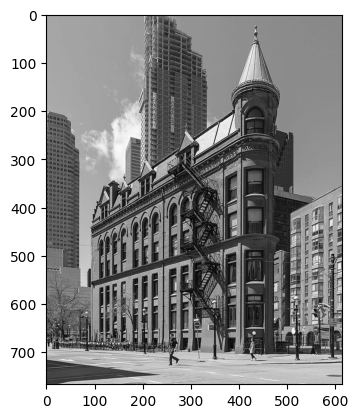

In [4]:
print(flatiron.shape)
plot_tensor(flatiron)

## Step 1. Filter image with x and y derivatives of Gaussian

In [5]:
def get_image_derivatives(img, sigma):
    sobel_x = torch.tensor([[1., 0., -1.],[2., 0., -2.],[ 1.,  0., -1.]]).unsqueeze(0)
    sobel_y = torch.tensor([[1., 2.,  1.],[0., 0.,  0.],[-1., -2., -1.]]).unsqueeze(0)
    # set kernel size based on 3*sigma rule
    kernel_size = 2 * int(sigma) * 3 + 1
    g2d = kornia.filters.get_gaussian_kernel2d((kernel_size, kernel_size), (sigma, sigma))
    gx = kornia.filters.filter2d(g2d.unsqueeze(0), sobel_x, behaviour='conv').squeeze(0)
    gy = kornia.filters.filter2d(g2d.unsqueeze(0), sobel_y, behaviour='conv').squeeze(0)
    img_dx = kornia.filters.filter2d(img, gx, behaviour='conv')
    img_dy = kornia.filters.filter2d(img, gy, behaviour='conv')
    return img_dx, img_dy

In [6]:
ix, iy = get_image_derivatives(flatiron, sigma=1.)

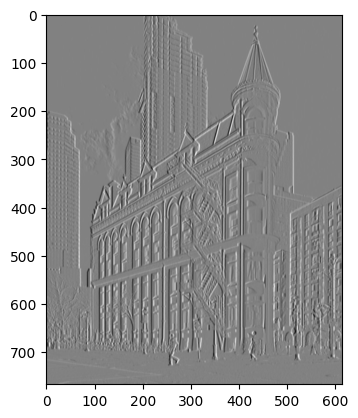

In [7]:
plot_tensor(ix)

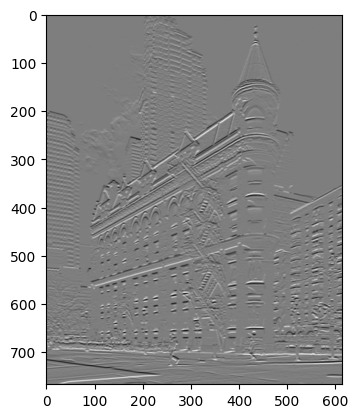

In [8]:
plot_tensor(iy)

## Step 2. Find magnitude and direction of gradient

In [9]:
def gradient_mag(img_dx, img_dy):
    mag = (img_dx * img_dx) + (img_dy * img_dy)
    return torch.sqrt(mag)

def gradient_dir(img_dx, img_dy):
    return torch.atan2(img_dx, img_dy)


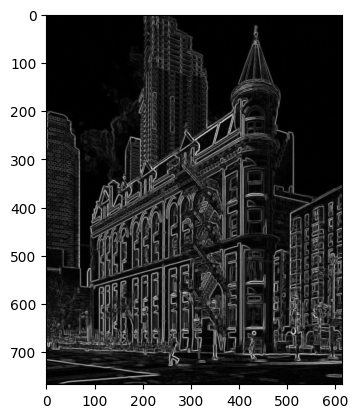

In [10]:
plot_tensor(gradient_mag(ix, iy))

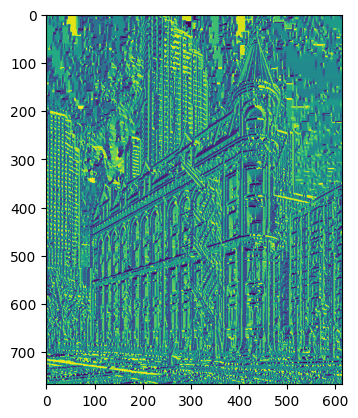

In [11]:
plot_tensor(gradient_dir(ix, iy), colour='viridis')

## Step 3. Non-maximum suppression and threshold

The `index_offsets` and `is_peak` helper functions help implement the non-maximum suppression by:
1. finding the two pixel `p_plus` and `p_minus` that are adjacent to a given pixel and in the gradient direction
2. determining if the given pixel `value` is a peak or not by comparing to the values of `p_plus` and `p_minus`

Since the gradient direction matrix is in angles from +pi to -pi, `nm_suppress` and `index_offsets` do some computations to convert these angles into array indices. This requires some explanation:
- Considering the unit circle centred on a given pixel, we see that each of it's immediate neighbours in a 3x3 grid can be identified by an angle that is a multiple of pi/4 (45 degrees).
- If we scale all of the values in the direction matrix by 4/pi and then round to the nearest whole number, we have classified the direction matrix into 8 bins that indicate the gradient direction of the pixel.
- We can then flatten the 3x3 matrix into a 1x9 matrix, which makes look up easier. When we do this, the centre pixel of the 3x3 matrix becomes element 5 (index=4) of the 1x9 array
- Since all 8 bins are known ahead of time, we can pre-compute the array indices for any angle in the direction matrix and simply look them up using a dictionary

In [12]:
def index_offsets(value):
    # Unit Circle                 Bin No.           Flat Bin No.
    # | 3pi/4 | pi/2 | pi/4 |     | 3 | 2 | 1 | ~~> | 3 | 2 | 1 | 4 | * | 0 |-3 |-2 |-1 |
    # |  pi   |  *   |   0  | ~~> | 4 | * | 0 |     Array Index
    # |-3pi/4 |-pi/2 |-pi/4 |     |-3 |-2 |-1 | ~~> | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
    bins = {
        4: [3, 5],
        3: [0, 8],
        2: [1, 7],
        1: [2, 6],
        0: [3, 5],
        -1: [0, 8],
        -2: [1, 7],
        -3: [2, 6],
        -4: [3, 5],
    }
    return bins[value]

def is_peak(mag_tensor, dir_tensor, centre = 4):
    angle = dir_tensor[centre].item()
    value = mag_tensor[centre].item()
    i1, i2 = index_offsets(angle)
    p_minus = mag_tensor[i1].item()
    p_plus = mag_tensor[i2].item()
    return (value > p_plus and value >= p_minus) or (value >= p_plus and value > p_minus)


In [13]:
def nm_suppress(mag_tensor, dir_tensor, eps = 1e-9):
    # rescale matrix of directions into multiples of pi/4 (45 degrees)
    # if we round these off, we can treat them as bins which helps speed look-up
    dir_rescale = torch.round(dir_tensor * 4 / np.pi).to(torch.int)

    # round down very small mag values to reduce search space
    mag_tensor = torch.where(mag_tensor >= eps, mag_tensor, 0)
    # only need to conduct non-max suppression for non-zero pixels
    nz_coords = torch.nonzero(mag_tensor).tolist()

    # pad the magnitude and direction matrices with a 0 border to avoid index issues
    mag_pad = torch.nn.functional.pad(mag_tensor, (1, 1, 1, 1), 'constant', 0)
    dir_pad = torch.nn.functional.pad(dir_rescale, (1, 1, 1, 1), 'constant', 0)

    peaks = torch.zeros(mag_tensor.shape)

    while nz_coords:
        _,_,i,j = nz_coords.pop()
        # grab 3x3 window of neighbours and flatten into 1D array
        mag_pad_3x3 = mag_pad[:,:,i:i+3,j:j+3].reshape((-1,))
        dir_pad_3x3 = dir_pad[:,:,i:i+3,j:j+3].reshape((-1,))
        if is_peak(mag_pad_3x3, dir_pad_3x3):
            peaks[:,:,i,j] = mag_tensor[:,:,i,j]
    return peaks

## Step 4. Hysteresis

In [14]:
def lo_and_not_visited(window_lo, window_visited):
    result = (window_lo * ~window_visited)
    return torch.nonzero(result).tolist()

def hysteresis(edges_lo, edges):
    # visited = edges
    queue = torch.nonzero(edges).tolist()
    queue = deque(queue)

    # pad visited and edges_lo to avoid index issues
    visited = torch.nn.functional.pad(edges, (1, 1, 1, 1), 'constant', 1)
    edges_lo = torch.nn.functional.pad(edges_lo, (1, 1, 1, 1), 'constant', 0)
    
    while queue:
        # coordinates for centre pixel
        _,_,h,w = queue.popleft()

        # offset coordinates in padded matrices
        hp, wp = h+1, w+1

        # all neighbours of centre pixel
        window_3x3_lo = edges_lo[:,:,hp-1:hp+2,wp-1:wp+2]
        window_3x3_visit = visited[:,:,hp-1:hp+2,wp-1:wp+2]

        # get coordinates of neighbours that are low and not yet visited
        offsets = lo_and_not_visited(window_3x3_lo, window_3x3_visit)
        for _,_,i,j in offsets:
            y = h + i
            x = w + j
            if (0 <= x < edges.shape[3]) and (0 <= y < edges.shape[2]):
                # add pixel as edge and append to queue
                edges[:,:,y,x] = 1
                queue.append([0,0,y,x])

        # mark all neighbours as visited
        visited[:,:,hp-1:hp+2,wp-1:wp+2] = torch.ones(window_3x3_visit.shape, dtype=torch.bool)
    return edges

## Canny Edges

In [15]:
def canny_edges(img, sigma, thresh_lo, thresh_hi):
    ix, iy = get_image_derivatives(img, sigma)
    m = gradient_mag(ix, iy)
    d = gradient_dir(ix, iy)
    nm = nm_suppress(m, d, thresh_lo)
    edges_lo = nm >= thresh_lo
    edges_hi = nm >= thresh_hi
    edges = hysteresis(edges_lo, edges_hi)
    return edges

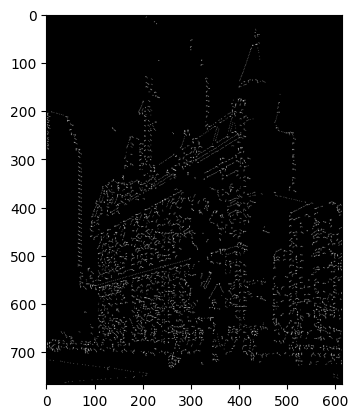

In [16]:
flatiron_edges = canny_edges(flatiron, 2.2, 0.05, 0.35)
plot_tensor(flatiron_edges)

In [17]:
save_tensor('flatiron_canny_edges.png', flatiron_edges)